# Predicting if the answer is right

#### Objective
For this project I aim to use neural networks and the provided data to predict if a user will answer an exam question correctly.

#### Outline of solution
- summarise user statistics (eg % of questions a user answers correctly, number of code activations etc)
- convert categorical user variables to one-hot-encoded columns
- join these to the questions table
- define a neural network
- split data into training and test
- fit data to training set and validate off test set
- tweak parameters in network definition to improve accuracy

#### Import libraries

In [101]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.utils import to_categorical

import livelossplot

#### Read in source files

In [103]:
user_info = pd.read_csv('assessment_data/user_info.csv')
code_activations = pd.read_csv('assessment_data/code_activations.csv')
chapters_read = pd.read_csv('assessment_data/chapters_read.csv')
questions_read = pd.read_csv('assessment_data/questions_read.csv')

#### One-hot-encode country and exam columns in the user table

In [104]:
user_info = pd.get_dummies(user_info, prefix='country', columns=['country_id'])
user_info = pd.get_dummies(user_info, prefix='exam', columns=['next_exam_type'])

#### Drop columns that we won't use

In [105]:
user_info.drop(columns=['marketing_source','signup_device', 'signup_os','register_date'],axis=1,inplace=True)

#### Split the questions data into training and test sets

In [117]:
train, test = train_test_split(questions_read, test_size=0.2, shuffle=True)

#### Create summarised data to use as predictors

The summarisations will be used as predictors when joined to the questions table. The summarisations used and the reasoning are as follows:

1. __Code activations per user.__ Want to find how many times a user has activated the product. The assumption is that more activations may imply greater engagement with the product. However this may not be a very good assumption and would need to validate this assumption with sales team around how these codes are distributed (monthly/yearly etc). Nevertheless I think this may be useful in a model.

2. __Chapters read per user.__ Find how many chapters each user has read. More reading = more knowledge :)

3. __Percent questions answered correctly per user.__ Find what percent of questions each user has answered correctly (from training set only). Joining this to the questions data will add useful information for the model.

4. __Number of questions attempted.__ Find the number of questions each user has attempted and join to the questions sheet.

In [118]:
num_codes = code_activations.groupby(by='user_id', as_index=False).count()
num_codes.rename(columns={'code_activation':'num_code_ctivations'}, inplace=True)

num_chaps_read = chapters_read[['user_id','chapter_id']].groupby(by='user_id', as_index=False).count()
num_chaps_read.rename(columns={'chapter_id':'num_chaps_read'}, inplace=True)

perct_questions_right = train[['user_id','was_answer_correct']].groupby(by='user_id', as_index=False).mean()
perct_questions_right.rename(columns={'was_answer_correct':'perct_correct'}, inplace=True)

num_questions_attempted = train[['user_id','was_answer_correct']].groupby(by='user_id', as_index=False).count()
num_questions_attempted.rename(columns={'was_answer_correct':'num_questions_attempted'}, inplace=True)

#### Join the above summaries to the questions data (training and test) using user_id as a join key

In [119]:
joined_train_data = pd.merge(train, num_chaps_read, on = 'user_id')
joined_train_data = pd.merge(joined_train_data, perct_questions_right, on = 'user_id')
joined_train_data = pd.merge(joined_train_data, num_questions_attempted, on = 'user_id')
joined_train_data = pd.merge(joined_train_data, user_info, on = 'user_id')
joined_train_data = pd.merge(joined_train_data, num_codes, on = 'user_id')

joined_test_data = pd.merge(test, num_chaps_read, on = 'user_id')
joined_test_data = pd.merge(joined_test_data, perct_questions_right, on = 'user_id')
joined_test_data = pd.merge(joined_test_data, num_questions_attempted, on = 'user_id')
joined_test_data = pd.merge(joined_test_data, user_info, on = 'user_id')
joined_test_data = pd.merge(joined_test_data, num_codes, on = 'user_id')

#### Drop columns that are not going to be used for training the model and split out predictor and target fields

In [120]:
X_train = joined_train_data.drop(columns=['user_id', 'question_id', 'answer_id','collection_id',
                                          'created_at', 'chapter_ids','was_answer_correct'],axis=1)
y_train = joined_train_data['was_answer_correct']

X_test = joined_test_data.drop(columns=['user_id', 'question_id', 'answer_id','collection_id',
                                          'created_at', 'chapter_ids','was_answer_correct'],axis=1)
y_test = joined_test_data['was_answer_correct']

#### Convert pandas dataframes to numpy arrays for use in model and convert target variables to correct datatype

In [121]:
X_train = X_train.values
y_train = to_categorical(y_train)

X_test = X_test.values
y_test = to_categorical(y_test)

#### Define the neural network

In [138]:
def baseline_model():
    model = Sequential()
    model.add(Dense(236,input_dim=236,activation='relu'))
    model.add(Dense(1000,activation='tanh'))
    model.add(Dense(2,activation='sigmoid'))
    adam = optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

net_model = baseline_model()

#call plotting library so we can plot accuracy and loss
plot_losses = livelossplot.PlotLossesKeras()

#### Fit the model to the training data and use the test set to validate

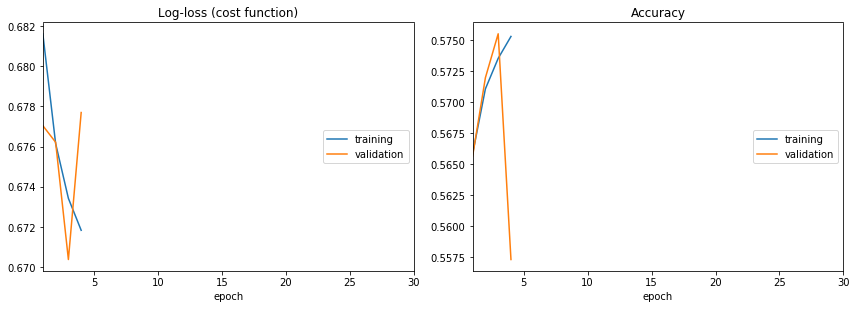

Epoch 5/30
 50000/310717 [===>..........................] - ETA: 1:03 - loss: 0.6708 - acc: 0.5755

KeyboardInterrupt: 

In [139]:
net_model.fit(X_train, y_train, epochs=30,
              batch_size=1000, class_weight='balanced',
              callbacks=[plot_losses],
              validation_data=(X_test, y_test))

### Ideas for improving the model

- 